<a href="https://colab.research.google.com/github/Dan-R-Sco/DeepLearning/blob/master/Flower_classifier_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Developing an AI application**


In this project, an image classifier is trained to recognize different species of flowers. The following [dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) will be used: dataset of 102 flower categories.


The project is broken down into multiple steps:

    Load and preprocess the image dataset
    Train the image classifier on your dataset
    Use the trained classifier to predict image content


# Import Modules

In [ ]:
#IMPORT MODULES

# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict


import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


You are good to go!  Training on GPU ...


# Load the data

To help the network generalize (leading to better performance)transformations are applied to the data:
- random scaling
- cropping
- flipping. 

Note that as I will be using a pre-trained network (VGG) the input data is resized to 224x224 pixels as required by the networks.

Validation data is not scaled or transformed but will be resized then crop the images to the appropriate size for the network.

The pre-trained networks available from torchvision were trained on the ImageNet dataset where each color channel was normalized separately. Therefore required to normalize the means and standard deviations of the images to what the network expects. 
For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [ ]:
#download a cat_dog dataset
#!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

--2020-06-28 17:17:20--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.80.227
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.80.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  36.2MB/s    in 9.7s    

2020-06-28 17:17:30 (34.0 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]



In [ ]:
#unzip the downloaded dataset
!mkdir flower_data

!tar -xzf flower_data.tar.gz -C flower_data

#unzip the downloaded dataset
#!unzip flower_data.zip;

## Define folders

In [ ]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
#name_json = 'cat_to_name.json'

## Load the Data

In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

## Define Transforms

In [ ]:
# DEFINE TRANSFORMS

train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])])


In [ ]:
# define where data is 
train_data = datasets.ImageFolder(train_dir, train_transforms)
val_datas = datasets.ImageFolder(valid_dir, valid_transforms)
test_data = datasets.ImageFolder(test_dir, test_transforms) 

In [ ]:
# define the loader

#if have problems with memory use smaller batchsizes
#common batch sizes: 1,2,4,8,16,32,64,128,256,512

batch_size=64
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(val_datas, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

#can use droplast if numbers dont add up

## Label Mapping

In [ ]:
import json

!wget https://raw.githubusercontent.com/bonn0062/image_classifier_pytorch/master/cat_to_name.json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

classes = list(cat_to_name.values())

--2020-06-28 17:17:38--  https://raw.githubusercontent.com/bonn0062/image_classifier_pytorch/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2020-06-28 17:17:38 (36.7 MB/s) - ‘cat_to_name.json’ saved [2218/2218]



In [ ]:
cat_to_name

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [ ]:
train_size = {len(train_data)}
print("Train size: {}".format(train_size))
valid_size = {len(val_datas)}
print("val size: {}".format(valid_size))
test_size = {len(test_data)}
print("Test size: {}".format(test_size))

Train size: {6552}
val size: {818}
Test size: {819}


## Plot Images

In [ ]:
#extract the index of the class in test dataset
idx_to_class = {val:key for key, val in test_data.class_to_idx.items()}

#get the class name, using the index, of the test dataset
def get_cat_name(index):
  """
  get the category name from the index of the label
  """
    return cat_to_name[idx_to_class[index]]

#used in transformation later on and for display now
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#plot 4x5 example of data
def plot_img(preds=None, is_pred=False):      
    """
    
    Take random image (default from training data)
    Normalise image
    Display with label above image
    20 examples given in 4 x 5 grid
    
    """  
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        #if is a prediction, take from validation data
        if is_pred:
            img_xy = np.random.randint(len(test_data));
            img = val_datas[img_xy][0].numpy()        
        
        #else take from training dataset
        else:
            img_xy = np.random.randint(len(train_data));
            img = train_data[img_xy][0].numpy()
            
        img = img.transpose((1, 2, 0))
        img = std * img + mean
        
        #get title of image
        if is_pred:
            plt.title(get_cat_name(preds[img_xy]) + "/" + get_cat_name(test_data[img_xy][1]))
        else:
            plt.title(str(get_cat_name(train_data[img_xy][1])))
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

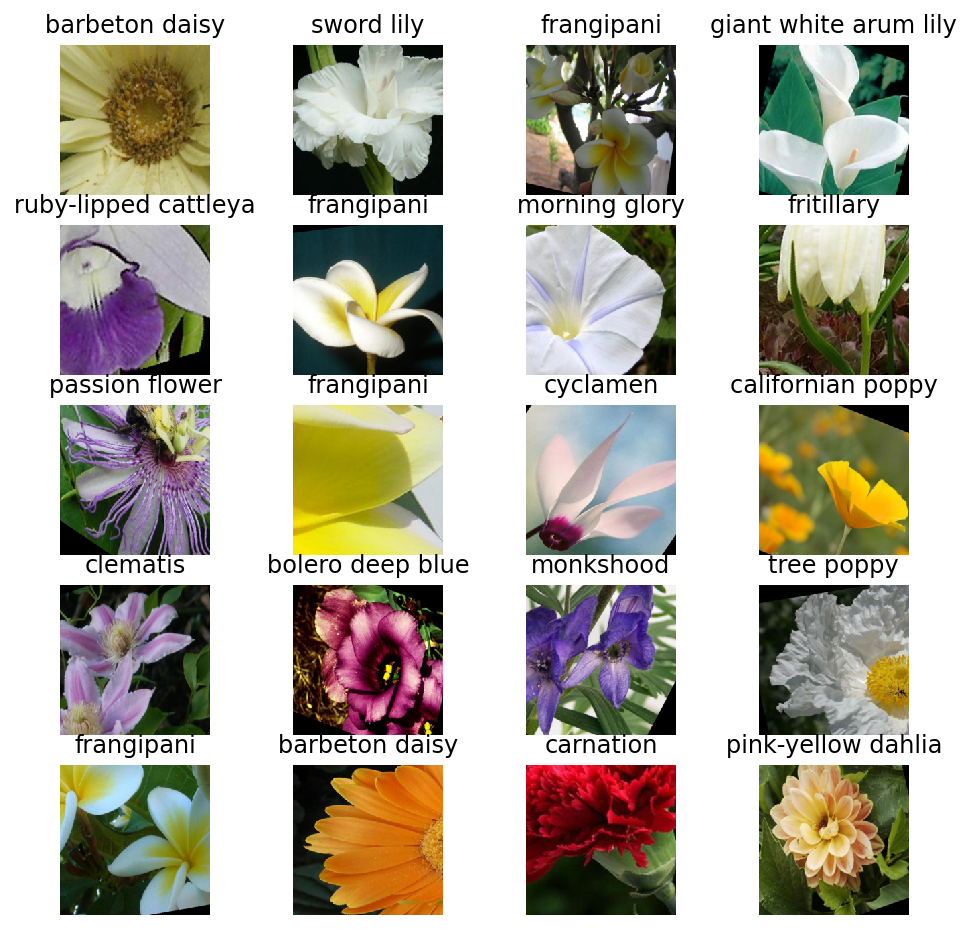

In [ ]:
#plot the train data
plot_img()

# Building and training the classifier

## load in VGG

In [ ]:
arch = 'vgg16'

model_ft = models.vgg16(pretrained=True) # loading a pre-trained(trained on image net) model from torchvision models

print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Reset gradient

In [ ]:
#dont update weights in model
for param in model_ft.parameters():
  param.requires_grad = False


## get number of neurons in last layer of pre-trained model

In [ ]:
#for vgg the last section is inside (classifier)
"""(classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)"""

#there are 1000 outputs for VGG

In [ ]:
num_ftrs = model_ft.classifier[-1] #returns the last layer in the model
num_ftrs

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model_ft.classifier[6].in_features # 4096 input features to model

4096

In [ ]:
#depending on model this can change, refer to https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

#Either edit the last layer or create own extension

#EDIT LAST LAYER

#map the in features
#num_classes = 102

#edit last layer of VGG16 to output 102 classes
#model_ft.classifier[6] = nn.Linear(4096,num_classes)

In [ ]:
#model_ft

In [ ]:
#add extension
#25088 is the input to the first classifier layer, shown above

#add softmax to last layer

model_ft.classifier = nn.Sequential(
                      nn.Linear(25088, 4096),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(4096, 4096),
                      nn.ReLU(),
                      nn.Dropout(p=0.4),
                      nn.Linear(4096,num_classes),
                      nn.LogSoftmax(dim=1)    
                      )

In [ ]:
#View network structure with the additional layers defined above
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Optional: load check point

In [ ]:
checkpoint = torch.load('checkpoint/ckpt_vgg.pth')
model_ft.load_state_dict(checkpoint['model'])
optimizer_ft.load_state_dict(checkpoint['optim'])

## Training network


In [ ]:
model_ft.to(device)

lr = 0.001
optimizer = optim.Adam(model_ft.classifier.parameters(),lr=lr)
criterion = nn.NLLLoss()

n_epochs = 20

#print_every = 20

running_loss = running_accuracy = 0
validation_losses = []
training_losses = []
best_acc = 0

for epoch in range(n_epochs):
    
    ###################
    # train the model #
    ###################
    model_ft.train() # prep model for training

    for data, target in trainloader:

        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_ft.forward(data) # log_class_prob
        
        # calculate the loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        # calculate errors between predicted output and the actual output and based on these two we calculate error gradient and do a back-propagation through our  
        # Autograd allows automatic gradient computation on the tensor when the .backword()method is called.
        loss.backward()
        
        # perform a single optimization step (parameter update)
        # performs a parameter update based on the current gradient 
        optimizer.step()
        
        #metrics
        log_class_probs = torch.exp(output) # log class probabilities
        top_ps, top_class = log_class_probs.topk(1, dim=1)  # get most likely class                
        matches = (top_class == target.view(*top_class.shape)).type(torch.FloatTensor) # check whether our predition is correct
        accuracy = matches.mean() # calculate accuracy


        #resetting optimizer gradient
        optimizer.zero_grad()
        #add metrics to running tracking
        running_loss += loss.item()
        running_accuracy += accuracy.item()
        
    ######################    
    # validate the model #
    ######################
    #NOTE NO BACKPROPOGATION in validation run, only done in training

    #eval meaning Dropout is deactivated and the data is just passed through input
    model_ft.eval() 

    #setting metrics
    validation_loss = 0
    validation_accuracy = 0

    #torch.no_grad() ensures no backpropagation - reduce memory consumption and is much quicker
    # - just disables the gradient calculation

    with torch.no_grad(): # Turn gradients off, for speed reasons
        for data, target in validloader:  # loop to get images and labels
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_ft.forward(data)
            # calculate the loss
            loss = criterion(output, target)

            class_prob = torch.exp(output)
            top_ps, top_class = class_prob.topk(1, dim=1) #retrieve top class and prob
            matches = (top_class == \
                                target.view(*top_class.shape)).type(torch.FloatTensor) #get number of correct preds
            accuracy = matches.mean() # calculate accuracy

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_accuracy += accuracy.item()
    
    # Tracking metrics
    validation_losses.append(running_loss/len(trainloader))
    training_losses.append(validation_loss/len(validloader))


    #print results
    print('Epoch {}'.format(epoch))
    print(f'Running Training Loss: {running_loss/print_every:.3f}')
    print(f'Running Training Accuracy: {running_accuracy/len(trainloader)*100:.2f}%')
    print(f'Validation Loss: {validation_loss/len(validloader):.3f}')
    print(f'Validation Accuracy: {validation_accuracy/len(validloader)*100:.2f}%')
    
    # Resetting metrics & turning on training mode
    running_loss = running_accuracy = 0
    model_ft.train()

    # Save checkpoint.
    if validation_accuracy > best_acc:
        print('Saving..')
        state = {
            'net': model_ft.state_dict(),
            'acc': validation_accuracy,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_vgg.pth')
        best_acc = validation_accuracy

Epoch0
Running Training Loss: 15.727
Running Training Accuracy: 31.12%
Validation Loss: 1.196
Validation Accuracy: 67.55%
Saving..
Epoch1
Running Training Loss: 9.641
Running Training Accuracy: 52.64%
Validation Loss: 0.900
Validation Accuracy: 75.84%
Saving..
Epoch2
Running Training Loss: 8.637
Running Training Accuracy: 56.79%
Validation Loss: 0.809
Validation Accuracy: 76.71%
Saving..
Epoch3
Running Training Loss: 8.083
Running Training Accuracy: 59.97%
Validation Loss: 0.761
Validation Accuracy: 79.10%
Saving..
Epoch4
Running Training Loss: 7.661
Running Training Accuracy: 62.87%
Validation Loss: 0.713
Validation Accuracy: 81.05%
Saving..
Epoch5
Running Training Loss: 7.424
Running Training Accuracy: 64.10%
Validation Loss: 0.616
Validation Accuracy: 82.98%
Saving..
Epoch6
Running Training Loss: 7.097
Running Training Accuracy: 65.02%
Validation Loss: 0.568
Validation Accuracy: 85.07%
Saving..
Epoch7
Running Training Loss: 7.101
Running Training Accuracy: 65.99%
Validation Loss: 0.

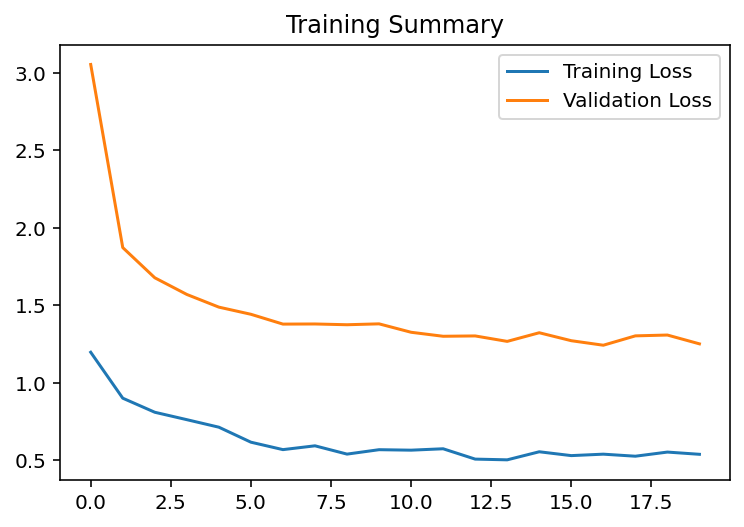

In [ ]:
plt.figure()
plt.title("Training Summary")
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.legend()
plt.show()

## Testing Network

In [ ]:
test_loss = 0
test_accuracy = 0

model_ft.eval()

print('Validation started')
start_time = time.time()

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    log_probabilities = model_ft.forward(inputs)
    probabilities = torch.exp(log_probabilities)
    top_probability, top_class = probabilities.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape)
    test_accuracy = test_accuracy + torch.mean(equals.type(torch.FloatTensor)).item()

end_time = time.time()
print('Test Validation ended')
validation_time = end_time - start_time
print('Test Validation time: {:.0f}m {:.0f}s'.format(validation_time / 60, validation_time % 60))

print("\nTest:\n  Loss: {:.4f}  ".format(test_loss / len(testloader)),
      "Accuracy: {:.4f}".format(test_accuracy / len(testloader)))

Validation started
Test Validation ended
Test Validation time: 0m 9s

Test:
  Loss: 0.0000   Accuracy: 0.8530


# Save model

In [ ]:
model_ft.class_to_idx = train_data.class_to_idx
in_features = 4096
number_classes = 102
batch_size = 64

checkpoint = {'network': 'vgg16',
              'input_size': in_features,
              'output_size': number_classes,
              'learning_rate': lr,      
              'batch_size': batch_size,
              'classifier' : model_ft,
              'epochs': n_epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model_ft.state_dict(),
              'class_to_idx': model_ft.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

# Loading the checkpoint

In [ ]:
def load_checkpoint(file_path):
    checkpoint = torch.load(file_path)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['network'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

model = load_checkpoint('checkpoint.pth')
print(model)

# Prediction
using the trained network, pass the image into the network and predivt the class of the flower in the image

## Image Preprocessing

Requires:
- resizing image to 256
- crop out centre of image to 224x224
- convert colour channels to 0-1 range #colour channels are usually 0-255 but model expects float
- Normalize image (subtract mean and std dev from each colour channel)




In [ ]:
#view a test image
image_path ='flower_data/test/1/image_06760.jpg'

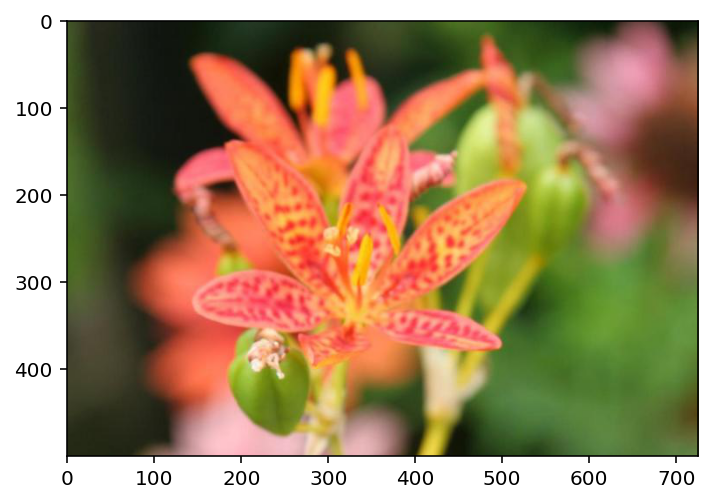

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image
    
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
    
with Image.open('flower_data/valid/102/image_08006.jpg') as image:
    plt.imshow(image)
    
model_ft.class_to_idx = train_data.class_to_idx

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
   
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    return ax

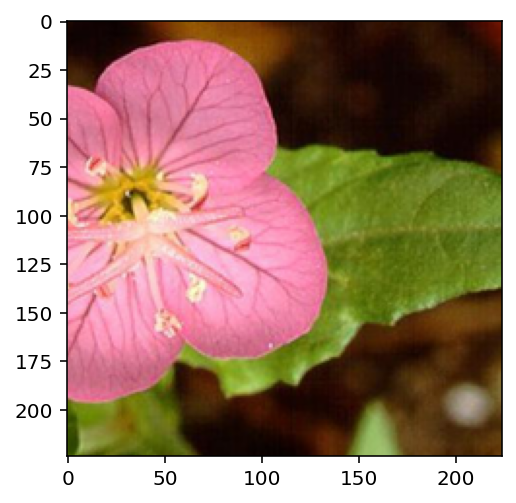

In [ ]:
imshow(process_image(image_path))

 function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

In [ ]:
def predict2(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [ ]:
class_names = train_data.classes

img_path = 'flower_data/valid/18/image_04252.jpg'
probs, classes = predict2(img_path, model_ft.to(device))
print(probs)
print(classes)
flower_names = [cat_to_name[class_names[e]] for e in classes]
print(flower_names)

[0.7464698553085327, 0.062365513294935226, 0.05258029326796532, 0.030184896662831306, 0.027941901236772537]
[12, 26, 32, 83, 40]
['peruvian lily', 'sweet william', 'ruby-lipped cattleya', 'clematis', 'sword lily']


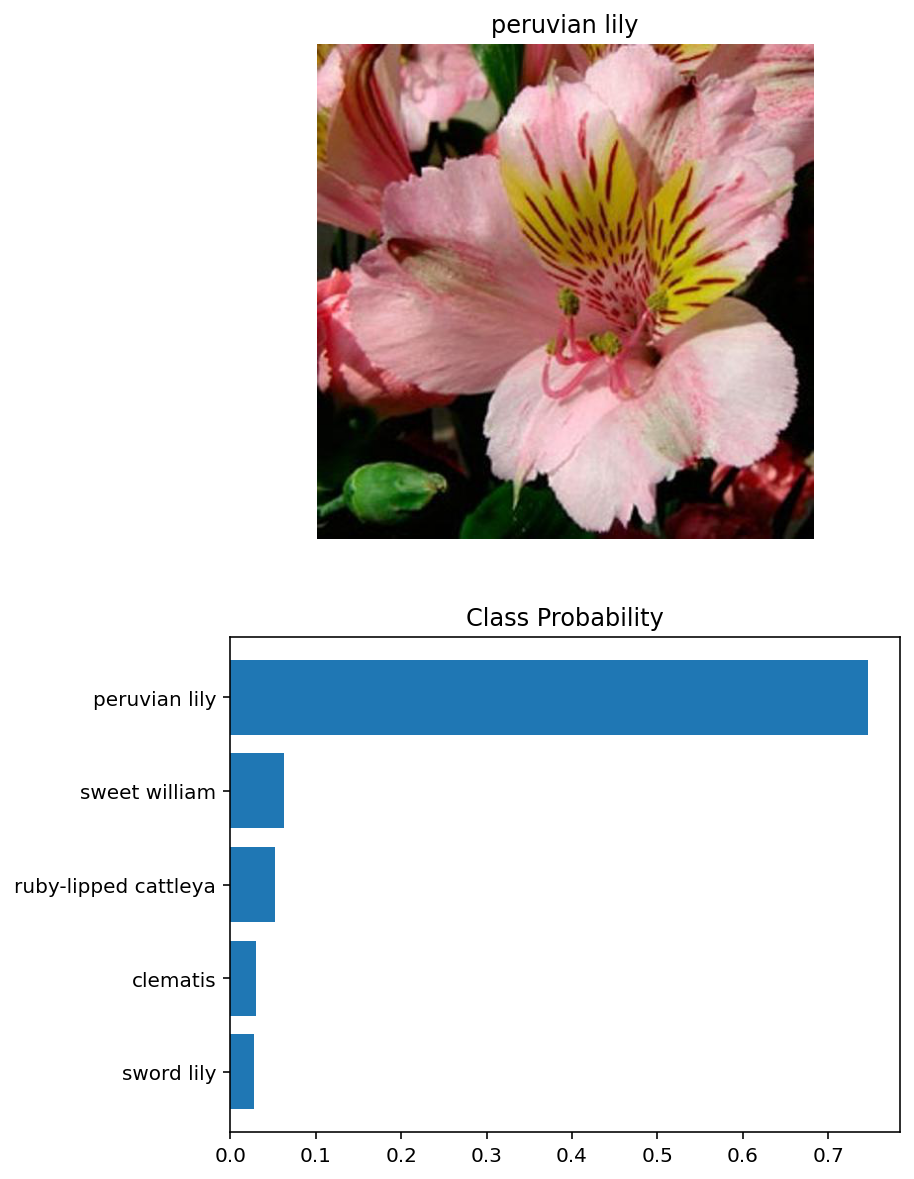

In [ ]:
def view_classify(img_path, prob, classes, mapping):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

view_classify(img_path, probs, classes, cat_to_name)

In [ ]:
#try for another

img_path = 'flower_data/valid/102/image_08006.jpg'

probs, classes = predict2(img_path, model_ft.to(device))
print(probs)
print(classes)

flower_names = [cat_to_name[class_names[e]] for e in classes]
print(flower_names)

[0.9911194443702698, 0.008113973774015903, 0.0004762170428875834, 0.0001969191653188318, 2.0958947061444633e-05]
[4, 79, 65, 60, 85]
['blackberry lily', 'toad lily', 'osteospermum', 'cautleya spicata', 'columbine']


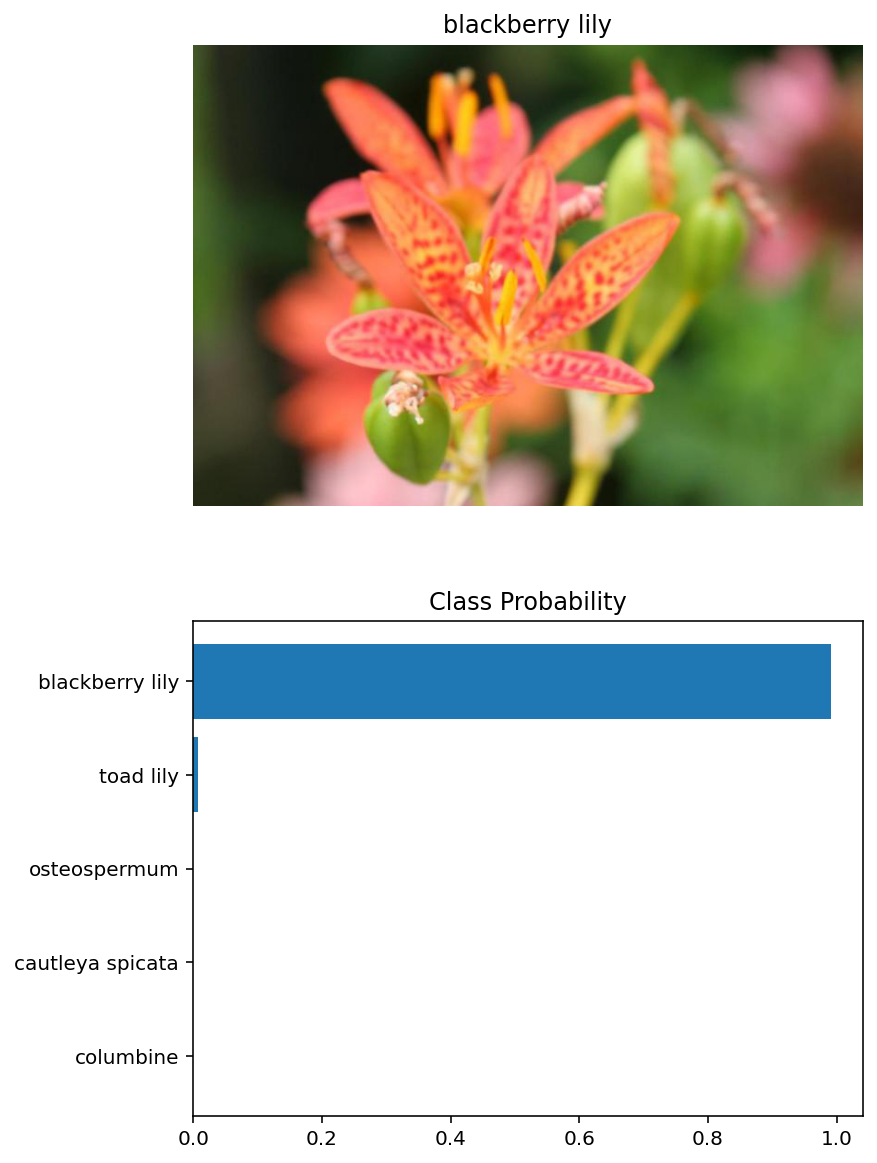

In [ ]:
view_classify(img_path, probs, classes, cat_to_name)